# Recurrent Neural Networks

## Encoder

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
%matplotlib inline

--2022-03-25 19:33:23--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 204.246.178.123, 204.246.178.122, 204.246.178.103, ...
Connecting to download.pytorch.org (download.pytorch.org)|204.246.178.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  10.8MB/s    in 0.3s    

2022-03-25 19:33:24 (10.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_hidden = 128

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('ÅšlusÃ rski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
AslusA rski
['Ermacora', 'Abandonato', 'Pavone', 'Battaglia', 'Abbate']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [2]:
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

class RNN_LIN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LIN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input, hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        hidden, cell = self.i2h(input, (hidden, cell))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden, cell

def initHidden(hidden_size):
    return torch.zeros(1, hidden_size)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [3]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    
criterion = nn.NLLLoss()
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn

category = German / line = Walter
category = Scottish / line = Alexander
category = Czech / line = Schmied
category = French / line = Palomer
category = Japanese / line = Fujimoto
category = German / line = Klein
category = French / line = Charron
category = Polish / line = Winogrodzki
category = Irish / line = Maolmhuaidh
category = Vietnamese / line = Chau


### Training and Testing with Linear Hidden Units

In [4]:
rnn = RNN_LIN(n_letters, n_hidden, n_categories)

def train(category_tensor, line_tensor):
    hidden = initHidden(n_hidden)

    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

import time
import math

n_iters = 200000
print_every = 10000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = initHidden(n_hidden)
    rnn.eval()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)
testloss_lin = all_test_losses
trainloss_lin = all_losses

10000 5% (0m 31s) 6989.5332 Sklavenitis / Spanish âœ— (Greek)
20000 10% (1m 5s) 1625.9062 Roggeveen / English âœ— (Dutch)
30000 15% (1m 38s) 50.2330 Snijder / Scottish âœ— (Dutch)
40000 20% (2m 11s) 535.6560 Vazquez / Vietnamese âœ— (Spanish)
50000 25% (2m 45s) 32.1063 Campos / Korean âœ— (Spanish)
60000 30% (3m 18s) 4.4826 Thai / Italian âœ— (Vietnamese)
70000 35% (3m 51s) 6.2178 Chweh / Arabic âœ— (Korean)
80000 40% (4m 24s) 1.7653 Jo / Chinese âœ— (Korean)
90000 45% (4m 58s) 875.4688 Schneider / Irish âœ— (Dutch)
100000 50% (5m 31s) 2596.5000 Santillian / Arabic âœ— (Spanish)
110000 55% (6m 4s) 19.1514 Kikui / Italian âœ— (Japanese)
120000 60% (6m 38s) 0.0000 Kauphsman / Czech âœ“
130000 65% (7m 11s) 0.0000 Espina / Spanish âœ“
140000 70% (7m 45s) 92.2178 Atiyeh / Polish âœ— (Arabic)
150000 75% (8m 18s) 4037.9648 Rooiakker / Vietnamese âœ— (Dutch)
160000 80% (8m 51s) 0.0001 David / English âœ“
170000 85% (9m 25s) 29.4971 Namiki / Dutch âœ— (Japanese)
180000 90% (9m 58s) 158.9531 Alm

#### Training and Testing with GRUs hidden units

In [5]:
rnn = RNN_GRU(n_letters, n_hidden, n_categories)

def train(category_tensor, line_tensor):
    hidden = initHidden(n_hidden)

    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []

# Just return an output given a line
def evaluate(line_tensor):
    hidden = initHidden(n_hidden)
    rnn.eval()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)
testloss_gru = all_test_losses
trainloss_gru = all_losses

10000 5% (1m 5s) 6.0736 Janshin / Korean âœ— (Russian)
20000 10% (2m 15s) 16.0934 Giles / Greek âœ— (French)
30000 15% (3m 24s) 0.9886 Toma / Japanese âœ— (Arabic)
40000 20% (4m 36s) 3.2040 Scheinberg / Chinese âœ— (German)
50000 25% (5m 47s) 0.0000 Kihara / Japanese âœ“
60000 30% (6m 57s) 15.1923 Essa / Japanese âœ— (Arabic)
70000 35% (8m 7s) 12.9299 Mozdzierz / Spanish âœ— (Polish)
80000 40% (9m 16s) 5.0119 Gray / English âœ— (Scottish)
90000 45% (10m 29s) 20.2168 Boutros / Greek âœ— (Arabic)
100000 50% (11m 40s) 13.2754 Sai / Chinese âœ— (Vietnamese)
110000 55% (12m 51s) 15.6875 Potter / German âœ— (English)
120000 60% (14m 0s) 19.7185 Taidhg / Chinese âœ— (Irish)
130000 65% (15m 9s) 3.8660 Babakhanoff / Arabic âœ— (Russian)
140000 70% (16m 19s) 0.0000 Ponkratov / Russian âœ“
150000 75% (17m 31s) 0.0000 Karahalios / Greek âœ“
160000 80% (18m 41s) 12.6411 Bordelon / Scottish âœ— (French)
170000 85% (19m 51s) 0.0001 Hebert / French âœ“
180000 90% (21m 1s) 7.3779 Campbell / English âœ—

#### Training and Testing with LSTM hidden units

In [6]:
rnn = RNN_LSTM(n_letters, n_hidden, n_categories)

def train(category_tensor, line_tensor):
    hidden = initHidden(n_hidden)
    cell = hidden

    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []

# Just return an output given a line
def evaluate(line_tensor):
    hidden = initHidden(n_hidden)
    cell = hidden
    rnn.eval()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)
    return output
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)
testloss_lstm = all_test_losses
trainloss_lstm = all_losses

10000 5% (1m 6s) 4.1318 Mohamed / Dutch âœ— (English)
20000 10% (2m 15s) 8.2915 Colombera / Japanese âœ— (Italian)
30000 15% (3m 25s) 8.8069 Otto / Italian âœ— (German)
40000 20% (4m 34s) 10.7713 Ophoven / Scottish âœ— (Dutch)
50000 25% (5m 45s) 24.0003 Puig / Vietnamese âœ— (Spanish)
60000 30% (6m 54s) 1.3766 Mccallum / German âœ— (Scottish)
70000 35% (8m 4s) 6.2938 Tomanek / Polish âœ— (Czech)
80000 40% (9m 13s) 3.0565 Jeong / Chinese âœ— (Korean)
90000 45% (10m 23s) 19.6125 Makricosta / Japanese âœ— (Greek)
100000 50% (11m 32s) 0.7578 Shalhoub / Arabic âœ“
110000 55% (12m 42s) 7.0023 Maroun / Russian âœ— (Arabic)
120000 60% (13m 51s) 0.0019 Awad / Arabic âœ“
130000 65% (15m 0s) 9.0554 Walentowicz / Spanish âœ— (Polish)
140000 70% (16m 10s) 1.9570 Chu / Chinese âœ— (Vietnamese)
150000 75% (17m 19s) 18.2852 Najjar / German âœ— (Arabic)
160000 80% (18m 29s) 0.0002 Andrysiak / Polish âœ“
170000 85% (19m 38s) 3.6015 Mahoney / Scottish âœ— (Irish)
180000 90% (20m 48s) 8.5316 Hertz / Spani

#### Plot the results

Text(0.5, 1.0, 'Test Loss for LSTM')

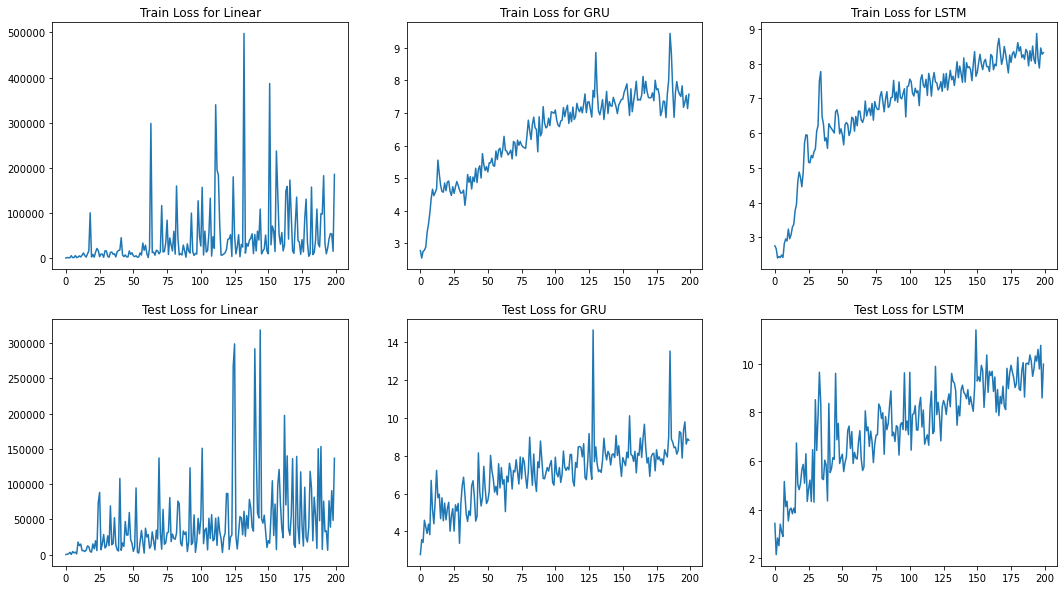

In [7]:
from matplotlib import pyplot as plt

_, [(a1,a2,a3),(a4,a5,a6)] = plt.subplots(2,3, figsize=(18,10))
a1.plot(trainloss_lin)
a1.set_title("Train Loss for Linear")
a2.plot(trainloss_gru)
a2.set_title("Train Loss for GRU")
a3.plot(trainloss_lstm)
a3.set_title("Train Loss for LSTM")
a4.plot(testloss_lin)
a4.set_title("Test Loss for Linear")
a5.plot(testloss_gru)
a5.set_title("Test Loss for GRU")
a6.plot(testloss_lstm)
a6.set_title("Test Loss for LSTM")

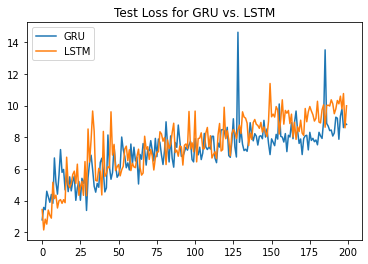

In [8]:
plt.plot(testloss_gru, label="GRU")
plt.plot(testloss_lstm, label="LSTM")
plt.title("Test Loss for GRU vs. LSTM")
plt.legend()
plt.show()

We can see that GRU and LSTM perform similarly at the beginning and GRU performs slightly better than LSTM towards the end. Linear has a huge test and train loss comparing to the other two hidden unit types. This is because GRU is basically a simplified version of LSTM and both aim to prevent vanishing gradient. GRU performs slightly better because it has less gates (2) comparing to LSTM (3), so that there are more gates for the gradient to flow through using LSTM hidden units. RNN performs really bad comparing to the other two since we are modeling a large dataset and the gradient of loss function decays with time. The vanishing gradient causes the RNN to have potentially high loss as epoch increases. LSTM has a separate memory cell to store information for a long period of time, and GRU has a similar and more simplified architecture as well, so they performs much better than RNN in a large sequential dataset.

## Decoder

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'NÃ©Ã l"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'NAA l


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

class RNN_PrevChar(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_PrevChar, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
class RNN_noPrevChar(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_noPrevChar, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

criterion = nn.NLLLoss()
learning_rate = 0.005

### Training and Testing using previous hidden unit, previous character and category

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn = RNN_PrevChar(n_letters, 128, n_letters)

n_iters = 10000
print_every = 500
plot_every = 100
all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    # optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    # optimizer.zero_grad()
    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    # optimizer.step()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    rnn.eval()
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
loss_i = all_test_losses

0m 20s (500 5%) 3.2205
0m 46s (1000 10%) 2.8731
1m 11s (1500 15%) 3.2786
1m 35s (2000 20%) 2.5881
2m 1s (2500 25%) 2.1308
2m 26s (3000 30%) 2.6084
2m 51s (3500 35%) 2.3838
3m 15s (4000 40%) 2.6159
3m 40s (4500 45%) 2.4574
4m 4s (5000 50%) 1.3224
4m 29s (5500 55%) 2.6828
4m 53s (6000 60%) 2.1119
5m 17s (6500 65%) 2.6701
5m 42s (7000 70%) 1.9421
6m 6s (7500 75%) 2.3212
6m 31s (8000 80%) 2.6118
6m 56s (8500 85%) 3.0537
7m 20s (9000 90%) 2.6766
7m 44s (9500 95%) 1.5721
8m 9s (10000 100%) 1.8674


### Training and Testing using previous hidden unit and previous character

In [ ]:
rnn = RNN_PrevChar(n_letters, 128, n_letters)

all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    # optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    #optimizer.zero_grad()
    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden) if i == 0 \
                    else rnn(torch.zeros(1, n_categories), input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    # optimizer.step()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    rnn.eval()
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden) if i == 0 \
                    else rnn(torch.zeros(1, n_categories), input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
loss_ii = all_test_losses

0m 20s (500 5%) 2.8717
0m 46s (1000 10%) 3.2600
1m 11s (1500 15%) 3.0896
1m 36s (2000 20%) 2.7957
2m 2s (2500 25%) 2.9092
2m 27s (3000 30%) 2.7856
2m 53s (3500 35%) 3.0593
3m 18s (4000 40%) 2.9258
3m 43s (4500 45%) 2.2107
4m 9s (5000 50%) 4.5791
4m 34s (5500 55%) 2.4133
5m 0s (6000 60%) 2.8960
5m 25s (6500 65%) 2.3330
5m 50s (7000 70%) 3.0229
6m 15s (7500 75%) 3.5966
6m 40s (8000 80%) 2.4043
7m 5s (8500 85%) 2.7190
8m 31s (9000 90%) 2.4069
9m 12s (9500 95%) 2.0578
9m 54s (10000 100%) 3.5845


### Training and Testing with previous hidden unit and category

In [ ]:
rnn = RNN_noPrevChar(n_letters, 128, n_letters)

all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    # optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    # optimizer.zero_grad()
    rnn.zero_grad()
    
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    # optimizer.step()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    rnn.eval()
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
loss_iii = all_test_losses

1m 6s (500 5%) 2.6600
2m 41s (1000 10%) 2.8030
3m 54s (1500 15%) 2.6369
5m 51s (2000 20%) 2.6179
16m 52s (2500 25%) 2.6223
17m 25s (3000 30%) 2.5839
17m 44s (3500 35%) 2.2673
18m 3s (4000 40%) 3.0789
18m 22s (4500 45%) 3.2748
18m 40s (5000 50%) 2.9138
18m 59s (5500 55%) 2.4793
19m 17s (6000 60%) 3.1539
19m 36s (6500 65%) 2.7168
19m 54s (7000 70%) 3.4228
20m 12s (7500 75%) 2.8037
20m 30s (8000 80%) 2.2442
20m 48s (8500 85%) 2.8372
21m 6s (9000 90%) 3.1800
21m 24s (9500 95%) 2.5645
21m 42s (10000 100%) 2.5478


### Training and Testing using previous hidden unit

In [ ]:
rnn = RNN_noPrevChar(n_letters, 128, n_letters)

all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    # optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.train()
    # optimizer.zero_grad()
    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden) if i == 0 \
                    else rnn(torch.zeros(1, n_categories), input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    # optimizer.step()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    rnn.eval()
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden) if i == 0 \
                    else rnn(torch.zeros(1, n_categories), input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
loss_iv = all_test_losses

0m 15s (500 5%) 3.2805
0m 33s (1000 10%) 2.6802
0m 52s (1500 15%) 3.1479
1m 10s (2000 20%) 3.0208
1m 29s (2500 25%) 3.1352
1m 47s (3000 30%) 2.2556
2m 6s (3500 35%) 3.1298
2m 25s (4000 40%) 2.3901
2m 43s (4500 45%) 2.6290
3m 2s (5000 50%) 3.1062
3m 20s (5500 55%) 2.8470
3m 39s (6000 60%) 1.8309
3m 57s (6500 65%) 2.8166
4m 16s (7000 70%) 2.3304
4m 34s (7500 75%) 2.6683
4m 53s (8000 80%) 3.2860
5m 11s (8500 85%) 3.1410
5m 29s (9000 90%) 2.5553
5m 48s (9500 95%) 2.9508
6m 7s (10000 100%) 2.5908


### Plot the results

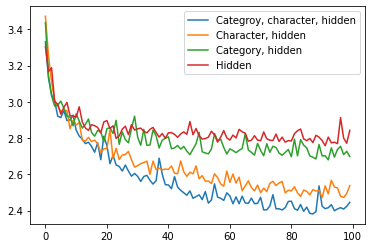

In [ ]:
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot(loss_i, label="Categroy, character, hidden")
plt.plot(loss_ii, label="Character, hidden")
plt.plot(loss_iii, label="Category, hidden")
plt.plot(loss_iv, label="Hidden")
plt.legend()
plt.show()

It seems that if we are just using the hidden unit from the previous step, the loss value is higher than having other information together in the neural network. Giving the hidden unit previous character (ii) is closer to (i) comparing to giving it the category (iii). The best scenerio is to have all the previous character, category, and hidden value as the input to the hidden unit (i). This is because the neural network could learn more information about the training set if we give it all the associated factors, and it cannot learn from the pattern between characters or difference between categories if we only give it the previous hidden state. 